KDD Cup 1999 : NSL-KDD Network Intrusion Detection
===
- B036060017 資管系四年級 謝威廷, 2018/4/16

## Introduction
Software to detect network intrusions protects a computer network from unauthorized users, including perhaps insiders.  The intrusion detector learning task is to build a predictive model (i.e. a classifier) capable of distinguishing between bad connections, called intrusions or attacks, and good normal connections.

Attacks fall into four main categories:
- DOS: denial-of-service, e.g. syn flood;
- R2L: unauthorized access from a remote machine, e.g. guessing password;
- U2R:  unauthorized access to local superuser (root) privileges, e.g., various buffer overflow attacks;
- Probing: surveillance and other probing, e.g., port scanning.

[Task Description](http://kdd.ics.uci.edu/databases/kddcup99/task.html)

## Outline
1. Auxiliary Fiunction : Evaluate Prediction Result
2. Data Loading
3. Encoding Categorical Variable with One Hot Encoding
4. First Trial with Ensemble Models
    - Random Forest, XGBoost, GBDT, LightGBM
    - Soft Major Voting Ensemble Classifer
5. Second Trial wtih Feature Engineering
    - Feature Reduction with feature importance
    - Lable Encoding
6. Conclusion    

## 1. Auxiliary Functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

random_seed = 17

# Show the Model Classification Report 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def show_clf_result(model_name, actual, prediction):
    acc = accuracy_score(actual, prediction)
    cm = confusion_matrix(actual, prediction)
    report = classification_report(actual, prediction)
    
    print("\n%s Classification Report" %model_name, "\n")
    print('Test Accuracy : %s' %acc, "\n")
    print("Confusion Matrix\n", cm, "\n")
    print('Classification Metrics\n', report)

## 2. Data Preprocessing

In [2]:
train = pd.read_csv('NSL_KDD-master/KDDTrain+.csv', header = None)
test = pd.read_csv('NSL_KDD-master/KDDTest+.csv', header = None)
data = pd.concat([train, test], axis = 0)


# Drop the last column which is unknown
data = data.drop(42, axis = 1)

# Assign the column name
columns_name = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 
                'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
                'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_hot_login',
                'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
                'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 
                'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
                'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type']
data.columns = columns_name

print('Train Data : ', train.shape)
print('Test Data :', test.shape)
print("Full Data : ", data.shape)
data.head()

Train Data :  (125973, 43)
Test Data : (22543, 43)
Full Data :  (148516, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


### 2.1 Create the Label Column
- Using attack dictionary to map four attack type lable : DoS, Probe, R2L, U2R 

In [3]:
attack_dict = {
    'normal': 'normal',
    
    'back': 'DoS',
    'land': 'DoS',
    'neptune': 'DoS',
    'pod': 'DoS',
    'smurf': 'DoS',
    'teardrop': 'DoS',
    'mailbomb': 'DoS',
    'apache2': 'DoS',
    'processtable': 'DoS',
    'udpstorm': 'DoS',
    
    'ipsweep': 'Probe',
    'nmap': 'Probe',
    'portsweep': 'Probe',
    'satan': 'Probe',
    'mscan': 'Probe',
    'saint': 'Probe',

    'ftp_write': 'R2L',
    'guess_passwd': 'R2L',
    'imap': 'R2L',
    'multihop': 'R2L',
    'phf': 'R2L',
    'spy': 'R2L',
    'warezclient': 'R2L',
    'warezmaster': 'R2L',
    'sendmail': 'R2L',
    'named': 'R2L',
    'snmpgetattack': 'R2L',
    'snmpguess': 'R2L',
    'xlock': 'R2L',
    'xsnoop': 'R2L',
    'worm': 'R2L',
    
    'buffer_overflow': 'U2R',
    'loadmodule': 'U2R',
    'perl': 'U2R',
    'rootkit': 'U2R',
    'httptunnel': 'U2R',
    'ps': 'U2R',    
    'sqlattack': 'U2R',
    'xterm': 'U2R'
}

# Transform Attack_type to Label
data['label'] = data['attack_type'].map(attack_dict)
data = data.drop(['attack_type'], axis = 1)
print(data['label'].value_counts())

normal    77053
DoS       53385
Probe     14077
R2L        3749
U2R         252
Name: label, dtype: int64


### 2.2 Indicate the Data Type of Each Column

In [4]:
label_idx = [40]
nominal_idx = [1, 2, 3]
binary_idx = [6, 11, 13, 14, 20, 21]
numeric_idx = list(set(range(41)).difference(label_idx).difference(nominal_idx).difference(binary_idx))

data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,DoS
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


### 2.3 Check Missing Value & Constant Variable
- There is no missing value in dataset.
- Variable **num_outbound_cmds** is constant that holds same value in each row.

In [5]:
# Check Missing Value
data is not None and not data.empty and not data.isnull().values.any()

# Check Constant Variable
for col in data.columns:
    if len(data[col].unique()) == 1:
        print("Remove Constant Variable : ", col)
        data = data.drop(col, axis=1)
print(data.shape)
data.head()

Remove Constant Variable :  num_outbound_cmds
(148516, 41)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,DoS
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


## 3. Encoding Categorical Variables with One Hot Encoding

In [6]:
data_num_ohe = pd.get_dummies(data.iloc[:, :-1])

data_ohe = pd.concat([data_num_ohe, data.iloc[:, -1]], axis = 1)
print('Full Data Shape after OHE : ', data_ohe.shape)
data_ohe.head()

Full Data Shape after OHE :  (148516, 122)


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,label
0,0,491,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,normal
1,0,146,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,normal
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,DoS
3,0,232,8153,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,normal
4,0,199,420,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,normal


### 3.1 Splitting Training, Testing Data

In [7]:
X_train, y_train = data_ohe.iloc[:train.shape[0], :-1], data_ohe.iloc[:train.shape[0], -1]
X_test, y_test = data_ohe.iloc[train.shape[0]:, :-1], data_ohe.iloc[train.shape[0]:, -1]

print('Training : ', X_train.shape, ' Testing : ', X_test.shape)
X_train.head()

Training :  (125973, 121)  Testing :  (22543, 121)


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,491,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,146,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,232,8153,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,0,199,420,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


## 4. First Trial with Ensemble Models
First Trial without tuning hyperparameter. 

### 4.1 Random Forest
- Accuracy : 0.764361442576

In [8]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(random_state = random_seed)
model_rf.fit(X_train, y_train)

predict_rf = model_rf.predict(X_test)
show_clf_result('Random Forest with OHE', y_test, predict_rf)


Random Forest with OHE Classification Report 

Test Accuracy : 0.764361442576 

Confusion Matrix
 [[6023  288    0    0 1147]
 [ 161 1618    0    0  642]
 [   0    3  133    2 2616]
 [   0    5    3    7  185]
 [  69  191    0    0 9450]] 

Classification Metrics
              precision    recall  f1-score   support

        DoS       0.96      0.81      0.88      7458
      Probe       0.77      0.67      0.71      2421
        R2L       0.98      0.05      0.09      2754
        U2R       0.78      0.04      0.07       200
     normal       0.67      0.97      0.80      9710

avg / total       0.82      0.76      0.72     22543



### 4.2 XGBoost : Extreme Gradient Boosting
- Accuracy : 0.729051146697

In [9]:
from xgboost import XGBClassifier

model_xgb = XGBClassifier(objective = 'multi:softmax',
                          n_jobs = -1,
                          random_state = random_seed)
model_xgb.fit(X_train, y_train,
              eval_set = [(X_train, y_train), (X_test, y_test)], 
              eval_metric = 'merror',
              early_stopping_rounds = 5,
              verbose = True)

predict_xgb = model_xgb.predict(X_test)
show_clf_result('XGBoost with OHE', y_test, predict_xgb)

[0]	validation_0-merror:0.029887	validation_1-merror:0.27259
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.029268	validation_1-merror:0.267356
[2]	validation_0-merror:0.024862	validation_1-merror:0.271392
[3]	validation_0-merror:0.022933	validation_1-merror:0.271836
[4]	validation_0-merror:0.023172	validation_1-merror:0.271836
[5]	validation_0-merror:0.02314	validation_1-merror:0.271126
[6]	validation_0-merror:0.023346	validation_1-merror:0.270949
Stopping. Best iteration:
[1]	validation_0-merror:0.029268	validation_1-merror:0.267356


XGBoost with OHE Classification Report 

Test Accuracy : 0.729051146697 

Confusion Matrix
 [[5355   76    0    0 2027]
 [ 337 1478    0    0  606]
 [   0    4  162    1 2587]
 [ 107    0    3   10   80]
 [  58  219    1    2 9430]] 

Classification Metrics
              precision    recall  f1-score   support

   

### 4.3 GBDT : Gradient Boosting Decision Tree
- Accuracy : 0.767732777359 

In [10]:
from sklearn.ensemble import GradientBoostingClassifier

model_gbdt = GradientBoostingClassifier(random_state = random_seed, verbose = 1)
model_gbdt.fit(X_train, y_train)

predict_gbdt = model_gbdt.predict(X_test)
show_clf_result('Gradient Boosting Decision Tree with OHE', y_test, predict_gbdt)

      Iter       Train Loss   Remaining Time 
         1      142028.0629            4.28m
         2      117303.4288            4.32m
         3       98525.4997            4.26m
         4       83517.6391            4.21m
         5       71333.2791            4.14m
         6       61270.9264            4.10m
         7       52851.7826            4.02m
         8       45877.1042            4.11m
         9       39930.5474            4.07m
        10       35011.5807            3.98m
        20       11052.8459            3.45m
        30        4861.1494            2.93m
        40        4593.1640            2.43m
        50        3819.5501            1.97m
        60        3375.6090            1.54m
        70        3084.0521            1.13m
        80        2884.6771           44.60s
        90        2693.2860           22.08s
       100        2587.9867            0.00s

Gradient Boosting Decision Tree with OHE Classification Report 

Test Accuracy : 0.767732777359 



### 4.4 LightGBM
- Accuracy : 0.773011577873

In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

#!pip install lightgbm
import lightgbm as lgb
model_lgb = lgb.LGBMModel(objective = 'multiclass', num_class = 5, random_state = random_seed)
model_lgb.fit(X_train, y_train,
              eval_metric = 'multi_error',
              eval_set = (X_test, y_test),
              early_stopping_rounds = 10,
              verbose = True)

predict = model_lgb.predict(X_test)
predict_lgb = []

for x in predict:
    predict_lgb.append(np.argmax(x))
    
show_clf_result('Light GBM with OHE', y_test, predict_lgb)

[1]	valid_0's multi_error: 0.227831
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's multi_error: 0.226988
[3]	valid_0's multi_error: 0.230848
[4]	valid_0's multi_error: 0.232223
[5]	valid_0's multi_error: 0.233199
[6]	valid_0's multi_error: 0.229606
[7]	valid_0's multi_error: 0.231336
[8]	valid_0's multi_error: 0.231114
[9]	valid_0's multi_error: 0.231336
[10]	valid_0's multi_error: 0.229073
[11]	valid_0's multi_error: 0.233154
[12]	valid_0's multi_error: 0.233066
Early stopping, best iteration is:
[2]	valid_0's multi_error: 0.226988

Light GBM with OHE Classification Report 

Test Accuracy : 0.773011577873 

Confusion Matrix
 [[6151   84    0    0 1223]
 [ 161 1985   22    0  253]
 [   0    4  238    3 2509]
 [   1   16    0   14  169]
 [  75  594    2    1 9038]] 

Classification Metrics
              precision    recall  f1-score   support

          0       0.96      0.82      0.89      7458
          1       0.74      0.82      0.78      2421
          

### 4.5 Soft Major Voting Ensemble Classifer
- Combining with the RF, GBDT, XGB, don't know why LightGBM sklearn api can't support VotingCliassifier
- Accuracay : 0.772878498869

In [12]:
from sklearn.ensemble import VotingClassifier

model_mv = VotingClassifier(estimators=[('rf', model_rf),
                                        ('gbdt', model_gbdt),
                                        ('xgb', model_xgb)], voting='soft', n_jobs = -1)
model_mv = model_mv.fit(X_train, y_train)

predict_mv = model_mv.predict(X_test)
show_clf_result('Major Voting', y_test, predict_mv)

      Iter       Train Loss   Remaining Time 
         1      142028.0629            5.52m
         2      117303.4288            5.33m
         3       98525.4997            5.14m
         4       83517.6391            5.08m
         5       71333.2791            5.03m
         6       61270.9264            4.95m
         7       52851.7826            4.85m
         8       45877.1042            4.74m
         9       39930.5474            4.64m
        10       35011.5807            4.59m
        20       11052.8459            3.98m
        30        4861.1494            3.41m
        40        4593.1640            2.85m
        50        3819.5501            2.31m
        60        3375.6090            1.81m
        70        3084.0521            1.33m
        80        2884.6771           52.24s
        90        2693.2860           25.71s
       100        2587.9867            0.00s

Major Voting Classification Report 

Test Accuracy : 0.772878498869 

Confusion Matrix
 [[6163   5

## 5. Second Trial : Feature Engineering
Have tried several GridSearchCV tuning above models, but didn't observe any significant improvements and also time-consuming. Thus, the further processes focus on feature engineering (i.e. different encoding techiniques) and using LightGBM, in order to overperform the acc metics.
- 5.1 Feature Engineering : Flag
- 5.2 Category Encoding : Label Encoding
- 5.3 Feature Reduction : Using LightGBM Feature Importance
- 5.4 Fine Tuning : GridSearchCV

### 5.1 Feature Engineering : Flag
- Revise Flag Variable : according to distribution, seperate to 4 types (SF, S0, REJ, others)
- Still has no big progres, Accuracy : 0.769241006077

In [13]:
flag_dict = {
    'SF' : 'SF',
    'S0' : 'S0',
    'REJ' : 'REJ',
    'RSTR' : 'others',
    'RSTO': 'others',
    'S1' : 'others',
    'SH' : 'others',
    'S3' : 'others',
    'S2' : 'others',
    'RSTOS0' : 'others',
    'OTH' : 'others'}

data_fe = data
data_fe['flag'] = data_fe['flag'].map(flag_dict)
data_fe['flag'].value_counts()

SF        89819
S0        36864
REJ       15083
others     6750
Name: flag, dtype: int64

In [14]:
data_flag_ohe = pd.get_dummies(data_fe.iloc[:, :-1])
data_flag_ohe = pd.concat([data_flag_ohe, data_fe.iloc[:, -1]], axis = 1)

print('Full Data Shape with FE Flag after OHE : ', data_flag_ohe.shape)

Full Data Shape with FE Flag after OHE :  (148516, 115)


In [15]:
X_train, y_train = data_flag_ohe.iloc[:train.shape[0], :-1], data_flag_ohe.iloc[:train.shape[0], -1]
X_test, y_test = data_flag_ohe.iloc[train.shape[0]:, :-1], data_flag_ohe.iloc[train.shape[0]:, -1]
print('Training : ', X_train.shape, ' Testing : ', X_test.shape)

Training :  (125973, 114)  Testing :  (22543, 114)


In [16]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

model_lgb = lgb.LGBMModel(objective = 'multiclass', num_class = 5, random_state = random_seed)
model_lgb.fit(X_train, y_train,
              eval_metric = 'multi_error',
              eval_set = (X_test, y_test),
              early_stopping_rounds = 10,
              verbose = True)

predict = model_lgb.predict(X_test)
predict_lgb = []

for x in predict:
    predict_lgb.append(np.argmax(x))
    
show_clf_result('Light GBM with Flag Feature Engineering', y_test, predict_lgb)

[1]	valid_0's multi_error: 0.230848
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's multi_error: 0.232179
[3]	valid_0's multi_error: 0.240651
[4]	valid_0's multi_error: 0.24145
[5]	valid_0's multi_error: 0.232755
[6]	valid_0's multi_error: 0.233465
[7]	valid_0's multi_error: 0.233199
[8]	valid_0's multi_error: 0.234929
[9]	valid_0's multi_error: 0.235018
[10]	valid_0's multi_error: 0.235905
[11]	valid_0's multi_error: 0.242337
Early stopping, best iteration is:
[1]	valid_0's multi_error: 0.230848

Light GBM with Flag Feature Engineering Classification Report 

Test Accuracy : 0.769241006077 

Confusion Matrix
 [[6149   93    0    0 1216]
 [ 161 1932   22    1  305]
 [   0   12  227    2 2513]
 [   1   15    0    8  176]
 [  75  609    0    1 9025]] 

Classification Metrics
              precision    recall  f1-score   support

          0       0.96      0.82      0.89      7458
          1       0.73      0.80      0.76      2421
          2       0.91     

###  5.2 Category Encoding : Label Encoding
- One Hot Encoding makes huge increase of dimensions, try Label Encoding to see whether improve the results, although it may implies there is ordinal relationship between cateogories.
- Well, as it turns out, it produces similiar result as OHE.
- Accuracy : 0.768087654704

In [17]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data_le = data_fe
data_le[data_fe.select_dtypes(['object']).columns] = data_fe.select_dtypes(['object']).apply(lambda x: le.fit_transform(x))
data_le.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,1,20,2,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,4
1,0,2,44,2,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,4
2,0,1,49,1,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0
3,0,1,24,2,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,4
4,0,1,24,2,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4


In [18]:
X_train, y_train = data_le.iloc[:train.shape[0], :-1], data_le.iloc[:train.shape[0], -1]
X_test, y_test = data_le.iloc[train.shape[0]:, :-1], data_le.iloc[train.shape[0]:, -1]

print('Training : ', X_train.shape, ' Testing : ', X_test.shape)

Training :  (125973, 40)  Testing :  (22543, 40)


In [19]:
model_lgb = lgb.LGBMModel(objective = 'multiclass', num_class = 5, random_state = random_seed)
model_lgb.fit(X_train, y_train,
              eval_metric = 'multi_error',
              eval_set = (X_test, y_test),
              early_stopping_rounds = 10,
              verbose = True)

predict = model_lgb.predict(X_test)
predict_lgb = []

for x in predict:
    predict_lgb.append(np.argmax(x))
    
show_clf_result('Light GBM with Label Encoding', y_test, predict_lgb)

[1]	valid_0's multi_error: 0.233465
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's multi_error: 0.235461
[3]	valid_0's multi_error: 0.256709
[4]	valid_0's multi_error: 0.255157
[5]	valid_0's multi_error: 0.254536
[6]	valid_0's multi_error: 0.25387
[7]	valid_0's multi_error: 0.255733
[8]	valid_0's multi_error: 0.255645
[9]	valid_0's multi_error: 0.255689
[10]	valid_0's multi_error: 0.255689
[11]	valid_0's multi_error: 0.238478
Early stopping, best iteration is:
[1]	valid_0's multi_error: 0.233465

Light GBM with Label Encoding Classification Report 

Test Accuracy : 0.768087654704 

Confusion Matrix
 [[6301  470    0    0  687]
 [ 161 1940    0    1  319]
 [   1   19   40  107 2587]
 [   1   19    0   10  170]
 [  83  601    1    1 9024]] 

Classification Metrics
              precision    recall  f1-score   support

          0       0.96      0.84      0.90      7458
          1       0.64      0.80      0.71      2421
          2       0.98      0.01     

### 5.3 Feature Reduction : Using LightGBM feature importance

In [20]:
imp_features = pd.Series(model_lgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)
imp_features = imp_features[imp_features > 1]
imp_nums = len(imp_features)
print("Select %s important variables from LightGBM." %imp_nums)

Select 25 important variables from LightGBM.


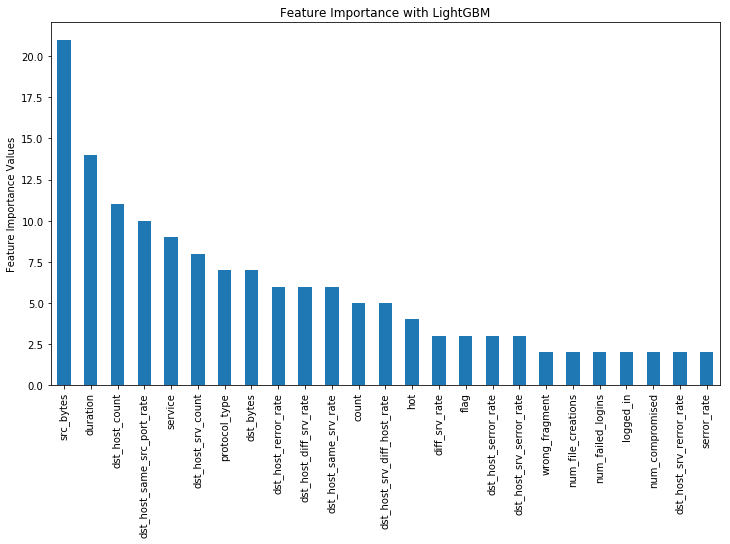

In [21]:
imp_features.plot(kind='bar', title='Feature Importance with LightGBM', figsize=(12,8))
plt.ylabel('Feature Importance Values')
plt.subplots_adjust(bottom=0.25)
plt.show()

In [22]:
imp_select = pd.Series(imp_features.axes[0][:imp_nums])

data_fr = data_le
data_fr = pd.concat([data_fr.loc[:, imp_select], data_le.iloc[:, -1]], axis = 1)
print("Full Data : ", data_fr.shape)

X_train, y_train = data_fr.iloc[:train.shape[0], :-1], data_fr.iloc[:train.shape[0], -1]
X_test, y_test = data_fr.iloc[train.shape[0]:, :-1], data_fr.iloc[train.shape[0]:, -1]

print('Training : ', X_train.shape, ' Testing : ', X_test.shape)

Full Data :  (148516, 26)
Training :  (125973, 25)  Testing :  (22543, 25)


In [23]:
model_lgb = lgb.LGBMModel(objective = 'multiclass', num_class = 5, random_state = random_seed)
model_lgb.fit(X_train, y_train,
              eval_metric = 'multi_error',
              eval_set = (X_test, y_test),
              early_stopping_rounds = 10,
              verbose = True)

predict = model_lgb.predict(X_test)
predict_lgb = []

for x in predict:
    predict_lgb.append(np.argmax(x))
    
show_clf_result('Light GBM with Label Encoding', y_test, predict_lgb)

[1]	valid_0's multi_error: 0.254979
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's multi_error: 0.256399
[3]	valid_0's multi_error: 0.258883
[4]	valid_0's multi_error: 0.263452
[5]	valid_0's multi_error: 0.263008
[6]	valid_0's multi_error: 0.25733
[7]	valid_0's multi_error: 0.256266
[8]	valid_0's multi_error: 0.25356
[9]	valid_0's multi_error: 0.254669
[10]	valid_0's multi_error: 0.25458
[11]	valid_0's multi_error: 0.254669
[12]	valid_0's multi_error: 0.256088
[13]	valid_0's multi_error: 0.239631
[14]	valid_0's multi_error: 0.239498
[15]	valid_0's multi_error: 0.238966
[16]	valid_0's multi_error: 0.238788
[17]	valid_0's multi_error: 0.238566
[18]	valid_0's multi_error: 0.238566
[19]	valid_0's multi_error: 0.238433
[20]	valid_0's multi_error: 0.240518
[21]	valid_0's multi_error: 0.240119
[22]	valid_0's multi_error: 0.240474
[23]	valid_0's multi_error: 0.24074
[24]	valid_0's multi_error: 0.241006
[25]	valid_0's multi_error: 0.241184
[26]	valid_0's multi_error

### 5.4 Fine Tuning with LightGBM
- Accuracy : 0.772301823182

In [24]:
model_lgb = lgb.LGBMModel(max_depth = 10,
                          learning_rate = 0.3,
                          subsample = 0.5,
                          colsample_bytree = 0.6,
                          reg_lambda = 0.01,
                          reg_alpha = 0.1,
                          objective = 'multiclass', 
                          num_class = 5, 
                          n_estimators = 1000,
                          random_state = random_seed)
model_lgb.fit(X_train, y_train,
              eval_metric = 'multi_error',
              eval_set = (X_test, y_test),
              early_stopping_rounds = 10,
              verbose = True)

predict = model_lgb.predict(X_test)
predict_lgb = []

for x in predict:
    predict_lgb.append(np.argmax(x))
    
show_clf_result('Light GBM with Fine Tuning', y_test, predict_lgb)

[1]	valid_0's multi_error: 0.252894
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's multi_error: 0.249301
[3]	valid_0's multi_error: 0.255778
[4]	valid_0's multi_error: 0.254802
[5]	valid_0's multi_error: 0.243756
[6]	valid_0's multi_error: 0.245531
[7]	valid_0's multi_error: 0.239187
[8]	valid_0's multi_error: 0.23311
[9]	valid_0's multi_error: 0.232267
[10]	valid_0's multi_error: 0.234086
[11]	valid_0's multi_error: 0.234663
[12]	valid_0's multi_error: 0.233154
[13]	valid_0's multi_error: 0.232489
[14]	valid_0's multi_error: 0.235905
[15]	valid_0's multi_error: 0.237191
[16]	valid_0's multi_error: 0.236038
[17]	valid_0's multi_error: 0.232844
[18]	valid_0's multi_error: 0.229783
[19]	valid_0's multi_error: 0.230803
[20]	valid_0's multi_error: 0.230138
[21]	valid_0's multi_error: 0.230094
[22]	valid_0's multi_error: 0.229561
[23]	valid_0's multi_error: 0.22823
[24]	valid_0's multi_error: 0.22894
[25]	valid_0's multi_error: 0.228497
[26]	valid_0's multi_erro

## 6. Conclusion
- After numerous trial-and-error attempts, such as Major Voting Ensemble Model etc., there are still no significant improvements
- Struggling with lower the level of overfitting that train-acc always higher than test-acc, even using serveral regularization techiniques the situation stays the same. Guessing the dataset needs more feature engineering processes to alleviate. But without hacker and network intrusion domain know-how, it seems to be a tough job to complete.
- Final, among all the experiments I have tried, the worst case is XGBoost archieves 72%, and the best case are **Major Voting Classifier** and **LightGBM with Fine Tuning archieve 77% Acc**.